In [1]:
%matplotlib inline
import sys, os, glob, copy, re, shutil

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS
from astropy.wcs import WCS

from astropy.io import fits

from astropy.table import QTable, Table, Column

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

### Get the SDSS quasars in Stripe 82 

In [2]:
qso_catalog_path = '/Users/colinburke/research/stripe82_quasars/dr16q_prop_May01_2024.fits'

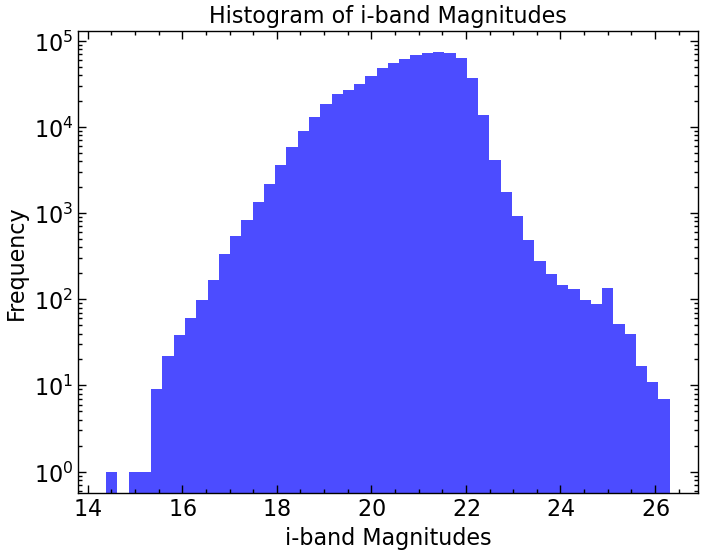

In [3]:
hdul = fits.open(qso_catalog_path)
fits_data = hdul[1].data  # Assuming the data is in the first extension    
fits_data_2 = hdul[2].data  # Assuming the data is in the first extension    

# Extract the i-band magnitudes (PSFMAG column, 4th index in the tuple)
g_band_magnitudes = fits_data_2['PSFMAG'][:, 1]

# Plot the histogram
plt.hist(g_band_magnitudes[g_band_magnitudes>0], bins=50, color='blue', alpha=0.7, log=True)
plt.xlabel('i-band Magnitudes')
plt.ylabel('Frequency')
plt.title('Histogram of i-band Magnitudes')
plt.show()

In [4]:
fits_data.columns

ColDefs(
    name = 'SDSS_NAME'; format = '18A'
    name = 'PLATE'; format = 'K'
    name = 'MJD'; format = 'K'
    name = 'FIBERID'; format = 'K'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'OBJID'; format = '20A'
    name = 'IF_BOSS_SDSS'; format = '10A'
    name = 'Z_DR16Q'; format = 'D'
    name = 'SOURCE_Z_DR16Q'; format = '12A'
    name = 'Z_FIT'; format = 'D'
    name = 'Z_SYS'; format = 'D'
    name = 'Z_SYS_ERR'; format = 'D'
    name = 'EBV'; format = 'D'
    name = 'SN_MEDIAN_ALL'; format = 'D'
    name = 'CONTI_FIT'; format = '5D'
    name = 'CONTI_FIT_ERR'; format = '5D'
    name = 'CONTI_STAT'; format = '2D'
    name = 'FEII_UV'; format = '3D'
    name = 'FEII_UV_ERR'; format = '3D'
    name = 'FEII_UV_EW'; format = 'D'
    name = 'FEII_UV_EW_ERR'; format = 'D'
    name = 'FEII_OPT'; format = '3D'
    name = 'FEII_OPT_ERR'; format = '3D'
    name = 'FEII_OPT_EW'; format = 'D'
    name = 'FEII_OPT_EW_ERR'; format = 'D'
    name = 'LOGL1350'; for

In [13]:
import h5py
import numpy as np

def load_s82_from_hdf5(file_path="s82_objs.h5"):
    """
    Optimized function to load data from an HDF5 file without explicit for loops.
    """
    with h5py.File(file_path, "r") as hdf:
        # Extract all object IDs and groups in one go
        object_ids = list(hdf.keys())
        groups = [hdf[obj_id] for obj_id in object_ids]

        # Extract attributes and datasets in a vectorized manner
        attributes = [
            {attr_key: group.attrs[attr_key] for attr_key in group.attrs.keys()}
            for group in groups
        ]
        datasets = [
            {
                key: {
                    sub_key: group[key][sub_key][...]
                    for sub_key in group[key].keys()
                } if isinstance(group[key], h5py.Group) else group[key][...]
                for key in group.keys()
            }
            for group in groups
        ]

        # Combine object IDs, attributes, and datasets into a single list of dictionaries
        s82_objs = [
            {"object_id": obj_id, **attr, **data}
            for obj_id, attr, data in zip(object_ids, attributes, datasets)
        ]

    return s82_objs

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Extract RA and DEC from lc_data
qso_ra = fits_data['ra']
qso_dec = fits_data['dec']
objids = fits_data['OBJID']

# Combine RA and DEC into a single array of coordinates
qso_stack = np.column_stack((qso_ra, qso_dec))

qso_coords = SkyCoord(ra=qso_stack[:, 0] * u.degree, dec=qso_stack[:, 1] * u.degree, frame='icrs')
len(qso_coords)

# Stripe 82 RA: 20h < RA < 4h (300 < RA < 60 deg), DEC: -1.25 < DEC < 1.25 deg
stripe82_mask = ((qso_ra > 300) | (qso_ra < 60)) & (qso_dec > -1.3) & (qso_dec < 1.3)

qso_ra_s82 = qso_ra[stripe82_mask]
qso_dec_s82 = qso_dec[stripe82_mask]
objids_s82 = objids[stripe82_mask]

qso_coords_s82 = SkyCoord(ra=qso_ra_s82 * u.degree, dec=qso_dec_s82 * u.degree, frame='icrs')
print(f"Number of Stripe 82 QSOs: {len(qso_coords_s82)}")

Number of Stripe 82 QSOs: 39827


### Get SuperCOSMOS data

http://ssa.roe.ac.uk/sql.html:

SELECT mjd, nominalRA, nominalDec, field.fieldID, plate.plateID, survey.surveyName
FROM field, plate, survey
WHERE (field.fieldID = plate.fieldID) AND (survey.surveyID = plate.surveyID)

http://ssa.roe.ac.uk/xmatch.html:

OBJID, SURVEYID, PLATEID, PARENTID, SOURCEID, RA, DEC, SMAG

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import pyvo
import pandas as pd
from tqdm import tqdm
import requests
import os
import h5py
import numpy as np
import time

def query_ssa_service(coords, radius=0.1/60, tap_url="http://wfaudata.roe.ac.uk/ssa-dsa/TAP", output_file="ssa_results.hdf5"):
    service = pyvo.dal.TAPService(tap_url)
    checkpoint_file = "checkpoint.txt"
    failed_coords_file = "failed_coords.txt"

    # Determine where to resume from
    resume_index = 0
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as f:
            line = f.readline()
            if line.strip().isdigit():
                resume_index = int(line.strip())

    # Open or create HDF5 file
    with h5py.File(output_file, "a") as h5f:
        for i in tqdm(range(resume_index, len(coords)), desc="Querying SSA service"):
            coord = coords[i]
            key = f"{coord.ra.deg:.6f}_{coord.dec.deg:.6f}"
            if key in h5f:
                continue

            adql_query = f"""
            SELECT objID, surveyID, plateID, parentID, sourceID, ra, dec, sMag FROM Detection
            WHERE ra BETWEEN ({coord.ra.deg} - {radius}/2.0) AND ({coord.ra.deg} + {radius}/2.0)
              AND dec BETWEEN ({coord.dec.deg} - {radius}/2.0) AND ({coord.dec.deg} + {radius}/2.0)
            """

            attempt = 0
            max_attempts = 5
            backoff = 10

            success = False
            while attempt < max_attempts:
                try:
                    results = service.search(adql_query)
                    results_table = results.to_table()
                    if len(results_table) > 0:
                        data_array = results_table.as_array()
                        h5f.create_dataset(key, data=data_array)
                    success = True
                    break
                except Exception as e:
                    attempt += 1
                    wait_time = backoff * (2 ** (attempt - 1))
                    print(f"Attempt {attempt}/{max_attempts} failed at index {i} with error: {e}. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)

            if not success:
                print(f"Failed permanently at index {i}. Skipping this coordinate.")
                with open(failed_coords_file, "a") as f:
                    f.write(f"{coord.ra.deg:.6f},{coord.dec.deg:.6f}\n")

            # Save progress checkpoint
            with open(checkpoint_file, 'w') as f:
                f.write(str(i + 1))

In [12]:
query_ssa_service(qso_coords_s82) # Should take around 2-3 hours

Querying SSA service: 100%|██████████| 39827/39827 [2:33:57<00:00,  4.31it/s]  


In [ ]:
import h5py
import pandas as pd

def load_ssa_hdf5_simple(path="roe_stars.hdf5"):
    """
    Fast loading of HDF5 datasets into a single pandas DataFrame.
    """
    with h5py.File(path, "r") as h5f:
        keys = list(h5f.keys())
        # Use list comprehension for speed
        frames = [
            pd.DataFrame.from_records(h5f[k][...])
            for k in keys
            if h5f[k].shape[0] > 0
        ]
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

### Save things as tables (much faster)

In [29]:
df_qso = load_ssa_hdf5_simple('wu_qso.hdf5')
df_qso.to_parquet("wu_qso.parquet")

In [ ]:
df_std = load_ssa_hdf5_simple("roe_stars.hdf5")
df_std.to_parquet("roe_stars.parquet")

### Load and make light curves

In [89]:
df_std = pd.read_parquet("roe_stars.parquet")
df_qso = pd.read_parquet("wu_qso.parquet")
df_std.columns = [col.upper() for col in df_std.columns]
df_qso.columns = [col.upper() for col in df_qso.columns]

In [90]:
df_qso

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG
0,847959688281351,3,197431,847959688281351,285009734896914,0.001819,-0.451121,19.018999
1,285009734896914,1,66359,285009734896914,285009734896914,0.002015,-0.451176,21.274000
2,566484711590289,2,131895,566484711590289,285009734896914,0.001949,-0.451143,19.684999
3,285009734891787,1,66359,285009734891787,285009734891787,0.006601,-0.559140,21.888000
4,285009734948080,1,66359,285009734948080,285009734948080,0.006698,0.583196,22.641001
...,...,...,...,...,...,...,...,...
81684,285018324886571,1,66361,285018324886571,285018324886571,9.991759,1.050093,21.299000
81685,566493301578903,2,131897,566493301578903,566493301578903,9.992899,0.602692,20.742001
81686,285018324829523,1,66361,285018324829523,285018324829523,9.992827,-0.230864,21.743000
81687,285018324860528,1,66361,285018324860528,285018324860528,9.995421,0.473056,20.937000


In [91]:
df_std

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG
0,285009734879241,1,66359,285009734879241,285009734879241,0.000127,-0.838752,18.952999
1,566484711575634,2,131895,566484711575634,285009734879241,0.000156,-0.838712,18.309999
2,847959688270127,3,197431,847959688270127,285009734879241,0.000083,-0.838790,18.077000
3,2536809548522580,9,590143,2536809548522580,285009734879241,0.000119,-0.838656,18.160999
4,285009734922687,1,66359,285009734922687,285009734922687,0.000210,0.077200,21.266001
...,...,...,...,...,...,...,...,...
3619044,285018324881695,1,66361,285018324881673,285018324881695,9.999781,0.950880,18.690001
3619045,566493301593848,2,131897,566493301593822,285018324881695,9.999740,0.950877,17.145000
3619046,847968278225969,3,197433,847968278225969,0,9.999487,0.950568,16.087000
3619047,847968278225974,3,197433,847968278225969,285018324881695,9.999603,0.950800,16.285999


### Read survey / MJD table

In [92]:
dat = fits.getdata('survey_table.fits')
t = Table(dat)

# Find columns that are multidimensional and flatten them
for name in t.colnames:
    if len(t[name].shape) > 1 and t[name].shape[1] == 1:
        t[name] = t[name].flatten()

df_survey = t.to_pandas()
df_survey

,MJD,NOMINALRA,NOMINALDEC,FIELDID,PLATEID,SURVEYNAME
0,0.000000,-999.999999,-999.999999,0,0,Not a survey
1,43426.573009,0.000000,-89.999982,65537,65537,SERC-J/EJ
2,50785.536971,0.000000,-89.999982,65537,131073,SERC-R/AAO-R
3,52588.728108,0.000000,-89.999982,65537,196609,SERC-I
4,46078.091005,0.000000,-89.999982,65537,262145,ESO-R
...,...,...,...,...,...,...
3530,35600.269946,205.275024,-11.773332,132673,329281,POSSI-E
3531,35600.320847,235.349987,-17.739999,132674,329282,POSSI-E
3532,35955.394531,223.224994,0.246667,132685,329293,POSSI-E
3533,35957.326741,211.249992,-5.766666,132688,329296,POSSI-E


In [94]:
# Perform a pandas join (merge) on 'PLATEID'
df_merged = pd.merge(df_std, df_survey, on='PLATEID', how='left')
df_merged

,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME
0,285009734879241,1,66359,285009734879241,285009734879241,0.000127,-0.838752,18.952999,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
1,566484711575634,2,131895,566484711575634,285009734879241,0.000156,-0.838712,18.309999,48556.498903,0.000000,0.0,66359.0,SERC-R/AAO-R
2,847959688270127,3,197431,847959688270127,285009734879241,0.000083,-0.838790,18.077000,49281.509058,0.000000,0.0,66359.0,SERC-I
3,2536809548522580,9,590143,2536809548522580,285009734879241,0.000119,-0.838656,18.160999,NaN,NaN,NaN,NaN,NaN
4,285009734922687,1,66359,285009734922687,285009734922687,0.000210,0.077200,21.266001,45175.786930,0.000000,0.0,66359.0,SERC-J/EJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619044,285018324881695,1,66361,285018324881673,285018324881695,9.999781,0.950880,18.690001,49655.494481,10.000004,0.0,66361.0,SERC-J/EJ
3619045,566493301593848,2,131897,566493301593822,285018324881695,9.999740,0.950877,17.145000,47467.520372,10.000004,0.0,66361.0,SERC-R/AAO-R
3619046,847968278225969,3,197433,847968278225969,0,9.999487,0.950568,16.087000,45265.568950,10.000004,0.0,66361.0,SERC-I
3619047,847968278225974,3,197433,847968278225969,285018324881695,9.999603,0.950800,16.285999,45265.568950,10.000004,0.0,66361.0,SERC-I


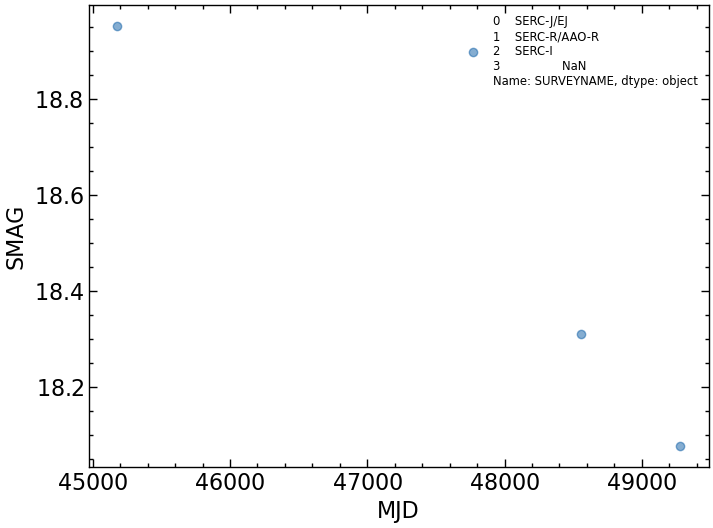

In [ ]:
mask_obj = df_merged['SOURCEID'] == 285009734879241
# Use same UPID to join multiple detections
plt.errorbar(df_merged[mask_obj]['MJD'], df_merged[mask_obj]['SMAG'],
            linestyle='none', marker='o', alpha=0.5, label=df_merged[mask_obj]['SURVEYNAME'])
plt.xlabel('MJD')
plt.ylabel('SMAG')
plt.legend(loc='best', fontsize='small')
plt.show()

## old

### Read the photometry files

In [ ]:
from astropy.table import vstack

# Concatenate all tables in table_lc
concatenated_table = vstack(table_lc)

concatenated_table.rename_columns(names=[col for col in concatenated_table.colnames],
    new_names=[col.upper() for col in concatenated_table.colnames])

# Match concatenated_table to the original SkyCoord using search_around_sky
catalog_coords = SkyCoord(ra=concatenated_table['RA'], dec=concatenated_table['DEC'], frame='icrs')
idx_catalog, idx_lc, sep2d, _ = search_around_sky(catalog_coords, lc_coords, seplimit=1*u.arcsec)

concatenated_table = concatenated_table[idx_catalog]
concatenated_table['idx_lc'] = idx_lc
concatenated_table['UP_NAME']  = objids[idx_lc]

# Save the concatenated table to a file
concatenated_table.write("concatenated_table.fits", format="fits", overwrite=True)

In [119]:
# Perform an inner join on 'fieldID' and 'plateID'
joined_table = table.join(concatenated_table, table_mjd, keys=['PLATEID'], join_type='left')

# Drop sources with PLATEID of zero
joined_table = joined_table[joined_table['PLATEID'] != 0]

joined_table['UP_NAME'] = joined_table['UP_NAME'].astype(int)

# Display the first few rows of the joined table
joined_table

OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,idx_lc,UP_NAME,MJD,NOMINALRA,NOMINALDEC,FIELDID
,,,,,deg,deg,mag,,,,,,
int64,int32,int32,int64,int64,float64,float64,float32,int64,int64,float64[1],float64[1],float64[1],int32[1]
285009734868975,1,66359,285009734868975,285009734868975,359.9827873635165,-1.063054433929827,22.136,21790,1444835,45175.786930404,0.0,0.0,66359
285009734971219,1,66359,285009734971219,285009734971219,359.98918959391926,1.0093144304933264,22.14,21786,1444829,45175.786930404,0.0,0.0,66359
285009734892887,1,66359,285009734892887,285009734892887,359.95318607198885,-0.5351116409312519,20.582,21797,1444852,45175.786930404,0.0,0.0,66359
285009734951951,1,66359,285009734951951,285009734951951,359.9613908276151,0.6578059690961566,21.404,21796,1444847,45175.786930404,0.0,0.0,66359
285009734927500,1,66359,285009734927500,285009734927500,2.412178673559342,0.17135162300079965,20.185,20782,1441859,45175.786930404,0.0,0.0,66359
285009734930088,1,66359,285009734930088,285009734930088,359.8961486964414,0.22425510805640908,22.18,21824,1444885,45175.786930404,0.0,0.0,66359
285009734866703,1,66359,285009734866703,285009734866703,2.4334932764960038,-1.1121053507709766,22.102,20775,1441835,45175.786930404,0.0,0.0,66359
285009734910569,1,66359,285009734910569,285009734910569,359.96558888938006,-0.16574981463780558,21.857,21795,1444845,45175.786930404,0.0,0.0,66359


In [ ]:
# Open the FITS file
fits_file = fits.open('results_0.fits')

# Print the structure of the FITS file
fits_file.info()

data_lc = fits_file[1].data

# Convert data_mjd and data_lc to Astropy Tables for easier manipulation
table_mjd = Table(data_mjd)
table_lc = Table(data_lc)

table_mjd['PLATEID'] = table_mjd['PLATEID'].flatten()
table_lc['PLATEID'] = table_lc['PLATEID'].flatten()

# Perform an inner join on 'fieldID' and 'plateID'
joined_table = table.join(table_lc, table_mjd, keys=['PLATEID'], join_type='left')

# Drop sources with PLATEID of zero
joined_table = joined_table[joined_table['PLATEID'] != 0]

joined_table['UP_NAME'] = joined_table['UP_NAME'].astype(int)

# Display the first few rows of the joined table
joined_table

Filename: results_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     86   3422R x 13C   [32A, 1D, 1D, 1J, 1D, 1K, 1I, 1J, 1K, 1K, 1D, 1D, 1E]   


UP_NAME,UP_RA,UP_DEC,UP_ID,DISTANCE,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME
int64,float64[1],float64[1],int32[1],float64[1],int64[1],int16[1],int32,int64[1],int64[1],float64[1],float64[1],float32[1],float64[1],float64[1],float64[1],int32[1],str16
1385133,48.356574,-0.633614,993,0.002129517959131314,285048389596673,1,66368,285048389596673,0,0.84398082,-0.01105855,19.283,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385111,48.614412,-1.197868,971,0.004891087335457222,285048389570660,1,66368,285048389570660,0,0.8484801599999999,-0.02090703,18.468,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385136,48.327791,0.606644,996,0.001529598935529965,285048389654120,1,66368,285048389654120,0,0.84347866,0.01058777,18.782,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385110,48.614429,-0.573355,970,0.004913652914835325,285048389599462,1,66368,285048389599462,0,0.84848051,-0.01000743,20.751,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385134,48.354119,-0.963405,994,0.005385403190300533,285048389581099,1,66368,285048389581099,0,0.84393704,-0.01681432,19.729,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385137,48.309579,-1.067336,997,0.00828489386727087,285048389576650,1,66368,285048389576650,0,0.84315887,-0.01862909,20.873,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385138,48.308717,-0.153812,998,0.003218319824445025,285048389617990,1,66368,285048389617990,0,0.84314661,-0.0026837000000000002,21.091,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385140,48.266765,0.595493,1000,0.002836647320117374,285048389653526,1,66368,285048389653526,0,0.84241319,0.010393040000000001,19.577,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385135,48.351984,-1.192678,995,0.007839121890116296,285048389570973,1,66368,285048389570973,0,0.84389935,-0.020815010000000002,21.407,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ


In [124]:
len(joined_table)

3408

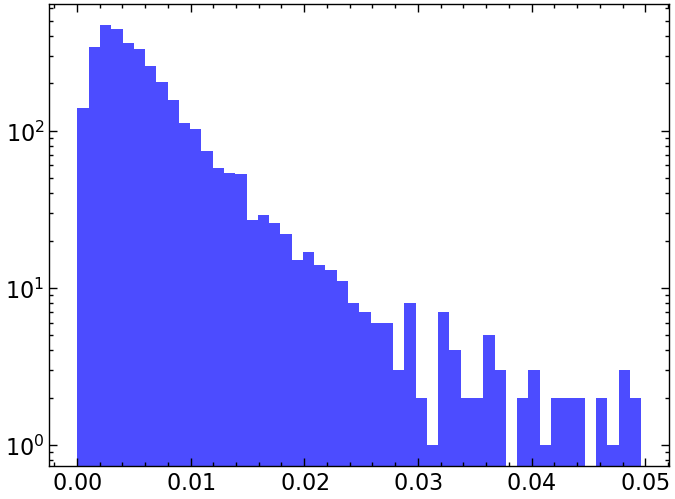

In [121]:
plt.hist(joined_table['DISTANCE'], bins=50, color='blue', alpha=0.7, log=True);

### Combine light curves

In [122]:
joined_table

UP_NAME,UP_RA,UP_DEC,UP_ID,DISTANCE,OBJID,SURVEYID,PLATEID,PARENTID,SOURCEID,RA,DEC,SMAG,MJD,NOMINALRA,NOMINALDEC,FIELDID,SURVEYNAME
int64,float64[1],float64[1],int32[1],float64[1],int64[1],int16[1],int32,int64[1],int64[1],float64[1],float64[1],float32[1],float64[1],float64[1],float64[1],int32[1],str16
1385133,48.356574,-0.633614,993,0.002129517959131314,285048389596673,1,66368,285048389596673,0,0.84398082,-0.01105855,19.283,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385111,48.614412,-1.197868,971,0.004891087335457222,285048389570660,1,66368,285048389570660,0,0.8484801599999999,-0.02090703,18.468,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385136,48.327791,0.606644,996,0.001529598935529965,285048389654120,1,66368,285048389654120,0,0.84347866,0.01058777,18.782,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385110,48.614429,-0.573355,970,0.004913652914835325,285048389599462,1,66368,285048389599462,0,0.84848051,-0.01000743,20.751,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385134,48.354119,-0.963405,994,0.005385403190300533,285048389581099,1,66368,285048389581099,0,0.84393704,-0.01681432,19.729,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385137,48.309579,-1.067336,997,0.00828489386727087,285048389576650,1,66368,285048389576650,0,0.84315887,-0.01862909,20.873,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385138,48.308717,-0.153812,998,0.003218319824445025,285048389617990,1,66368,285048389617990,0,0.84314661,-0.0026837000000000002,21.091,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385140,48.266765,0.595493,1000,0.002836647320117374,285048389653526,1,66368,285048389653526,0,0.84241319,0.010393040000000001,19.577,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ
1385135,48.351984,-1.192678,995,0.007839121890116296,285048389570973,1,66368,285048389570973,0,0.84389935,-0.020815010000000002,21.407,47772.751002777,44.99999101,0.0,66368,SERC-J/EJ


In [123]:
len(matched_lc_data)

984

Plotting 1384141


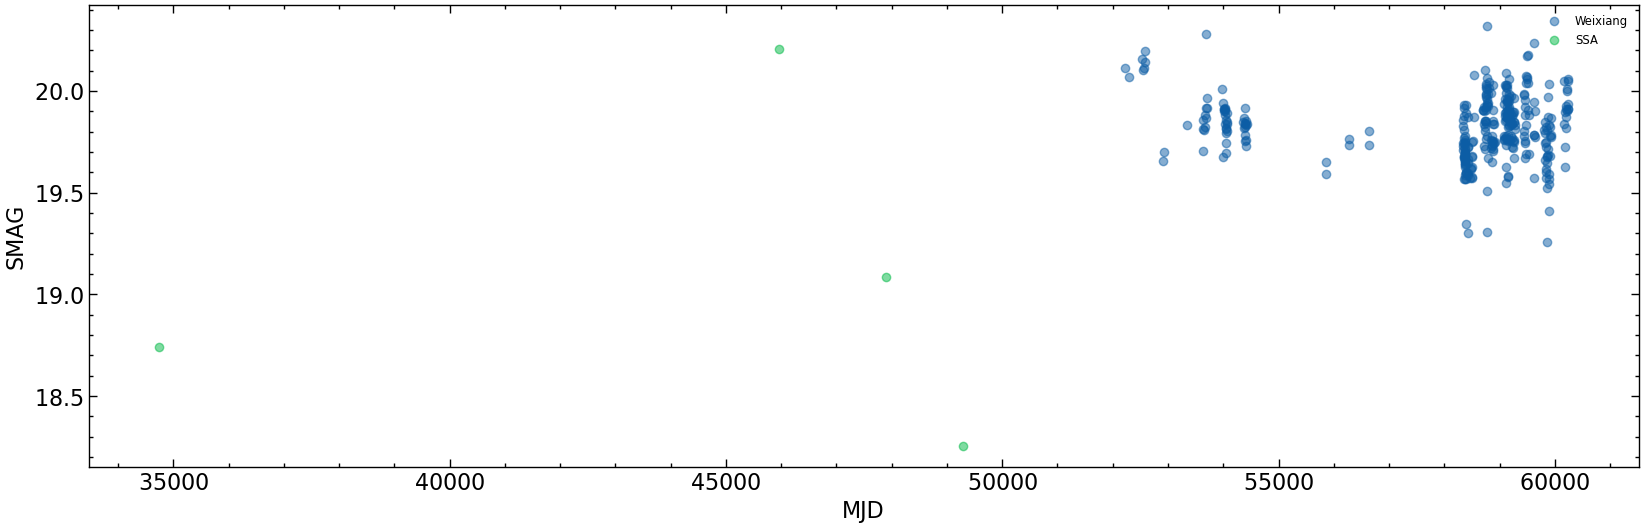

Plotting 1384142


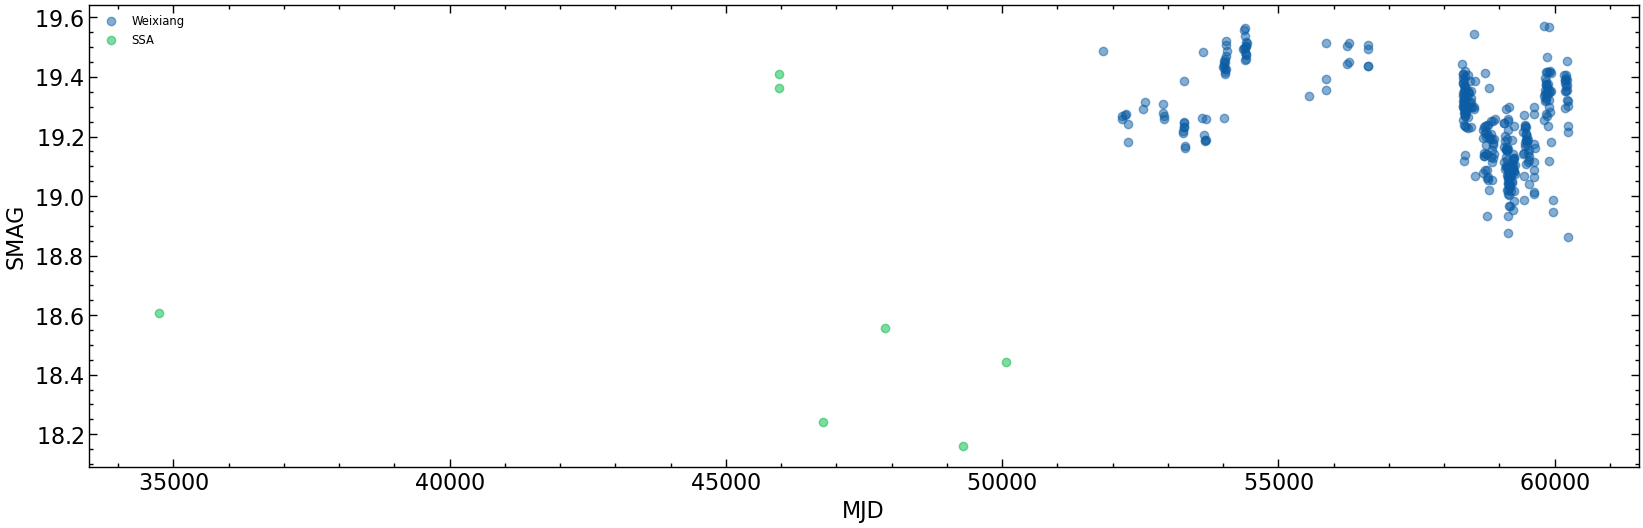

Plotting 1384143


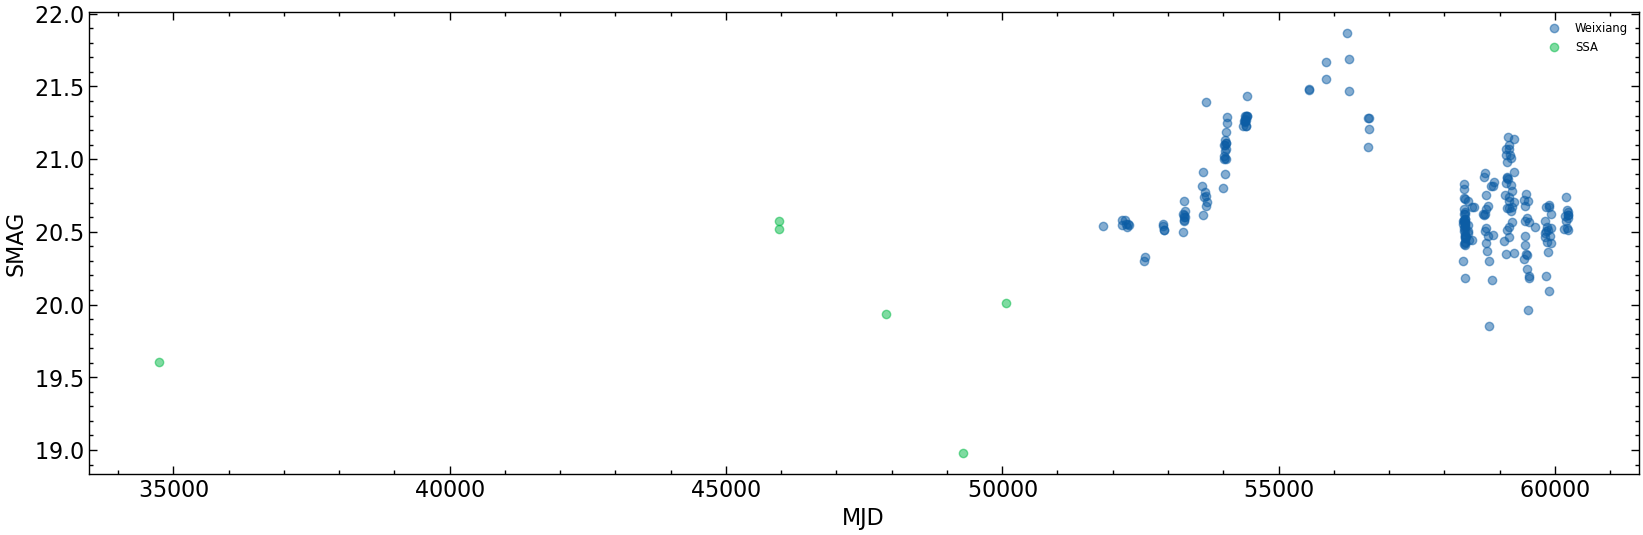

Plotting 1384144


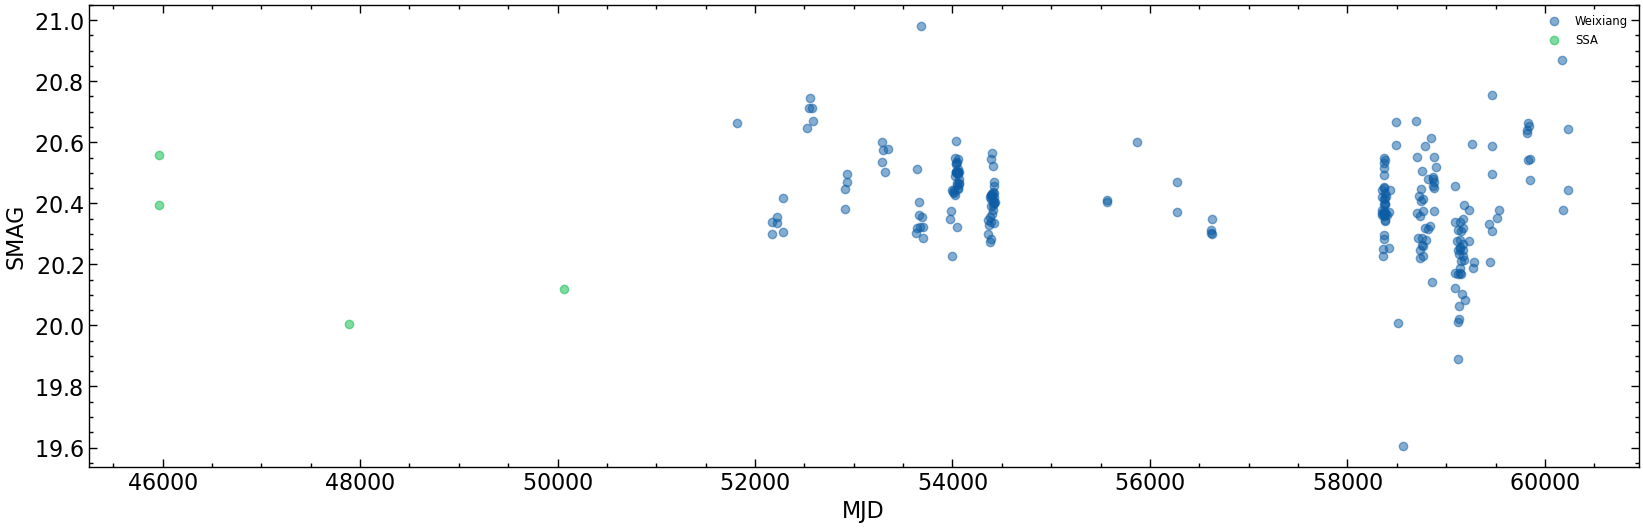

Plotting 1384145


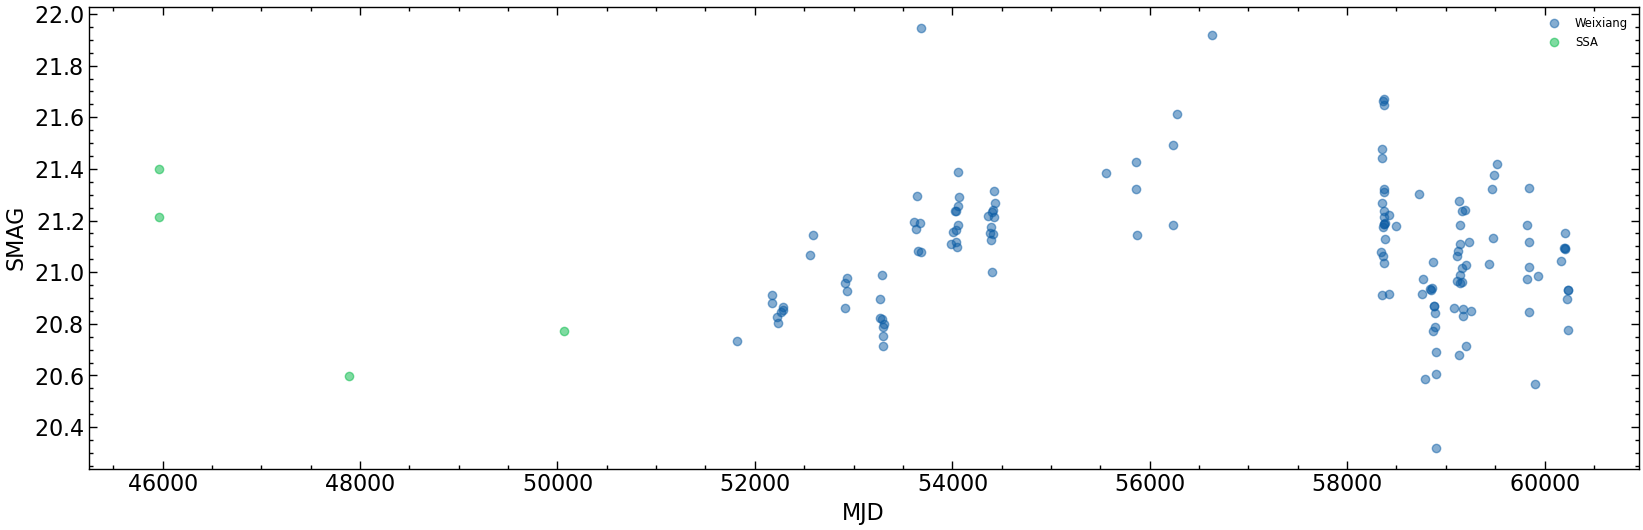

Plotting 1384146


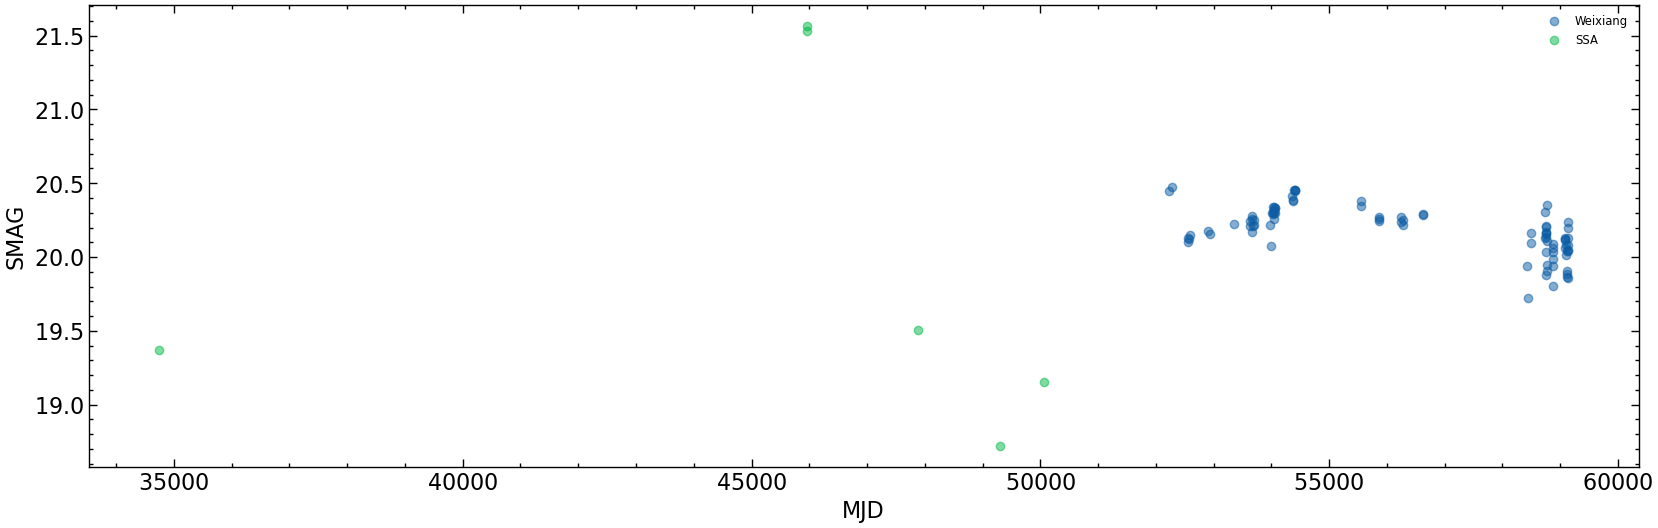

Plotting 1384147


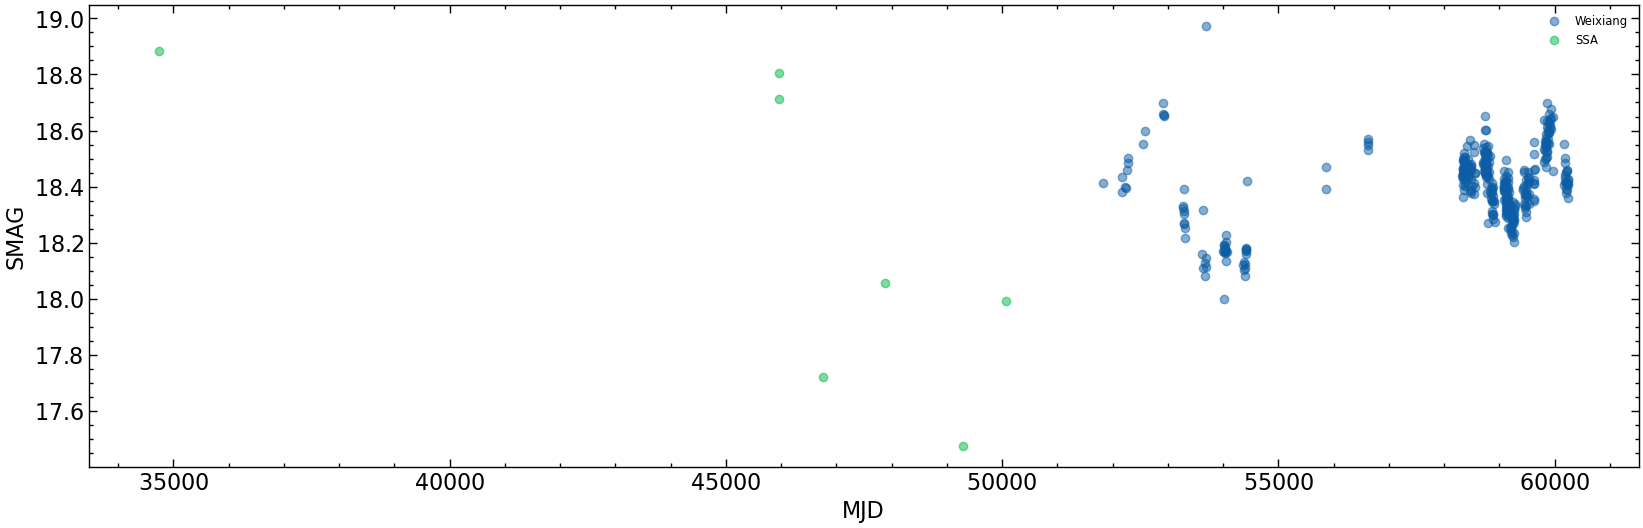

Plotting 1384148


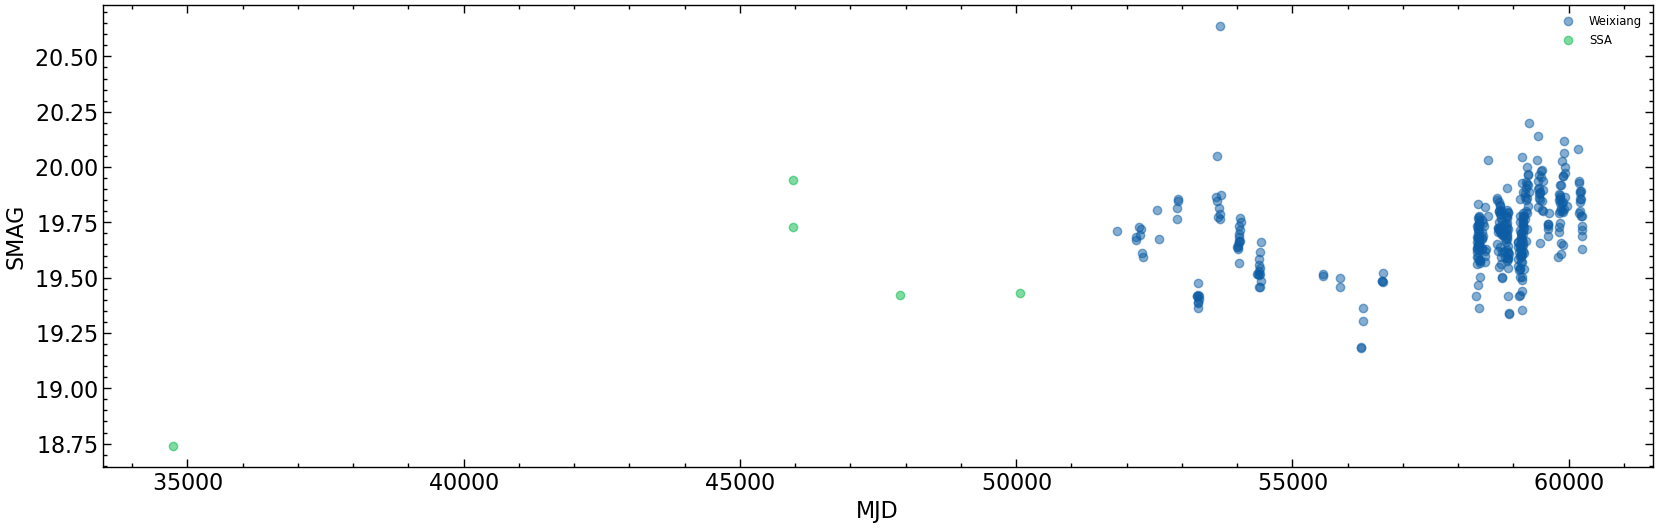

Plotting 1384149


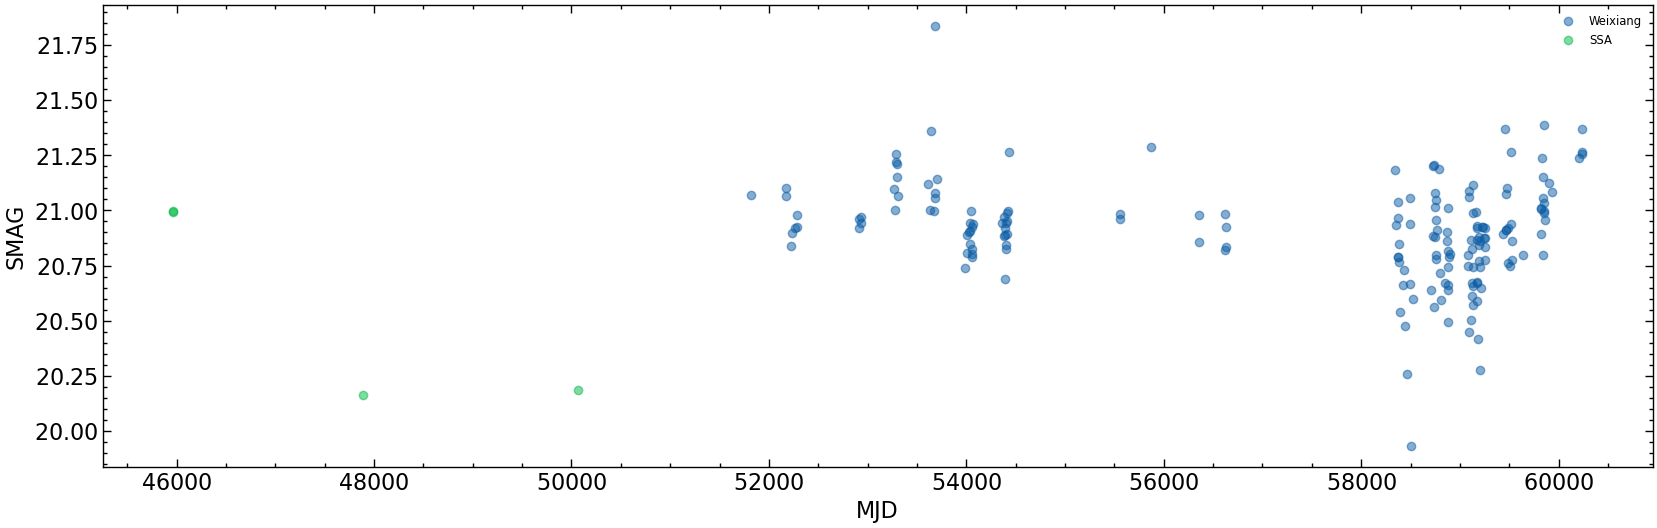

Plotting 1384150


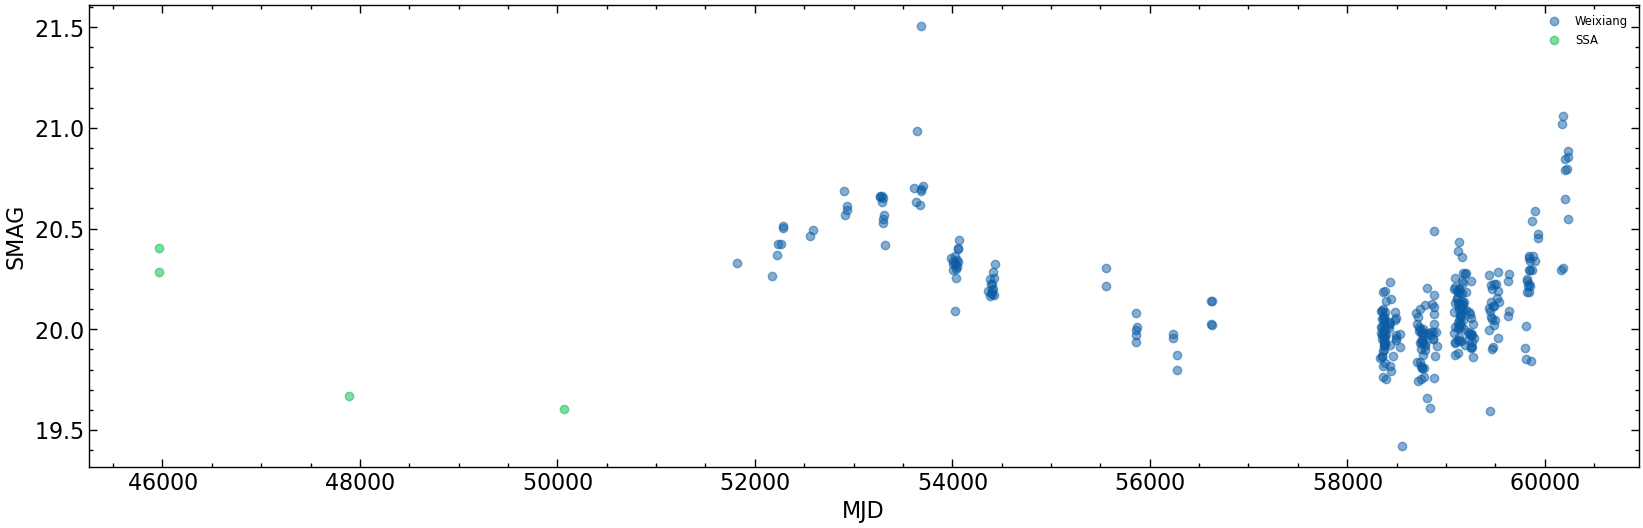

Plotting 1384151


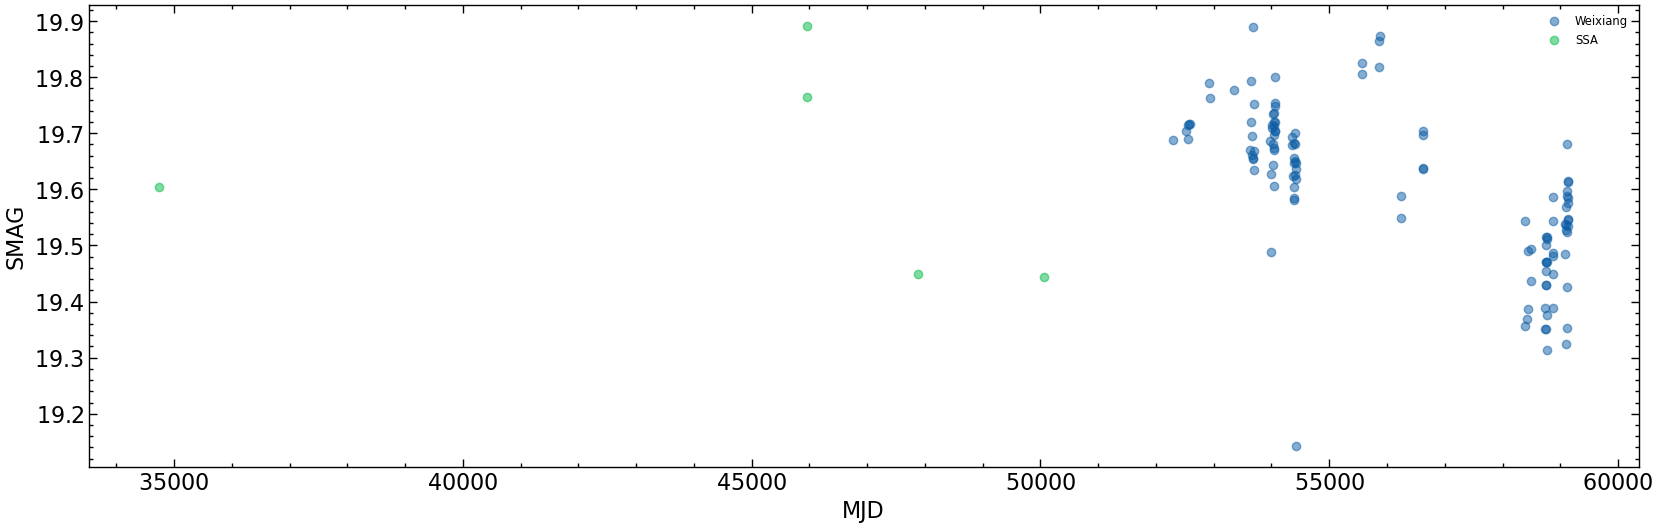

Plotting 1384152


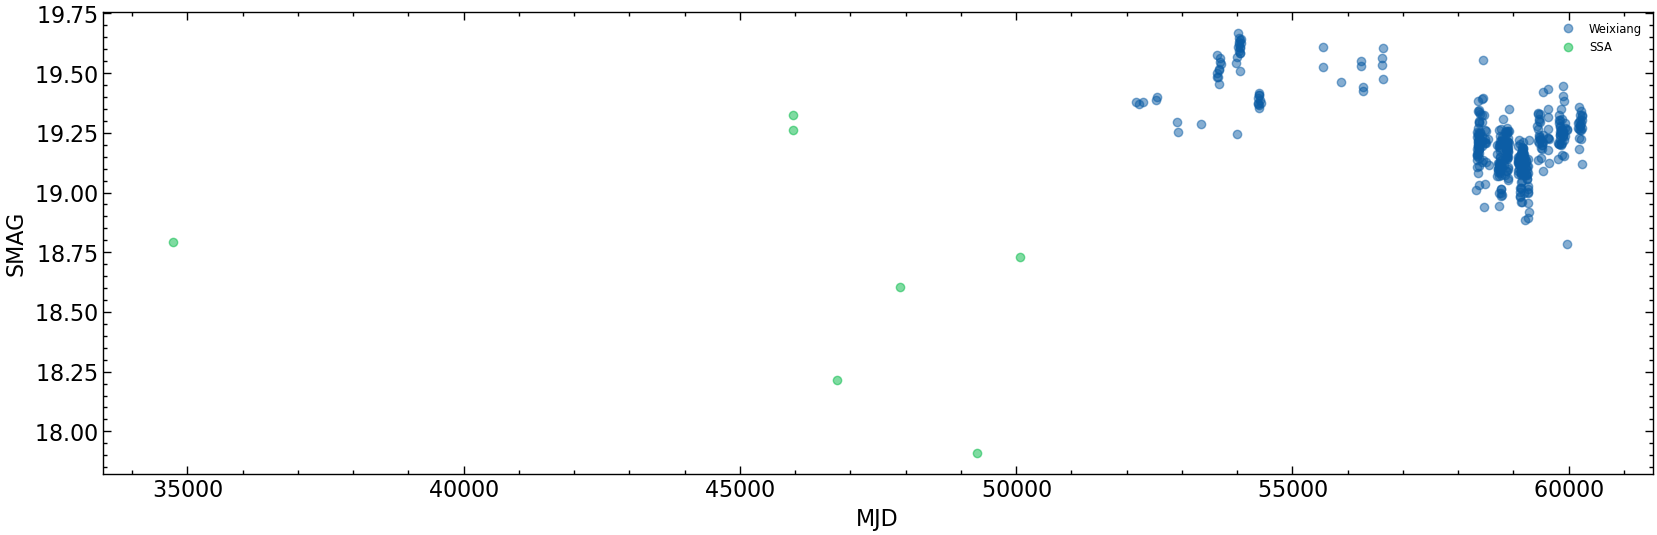

Plotting 1384153


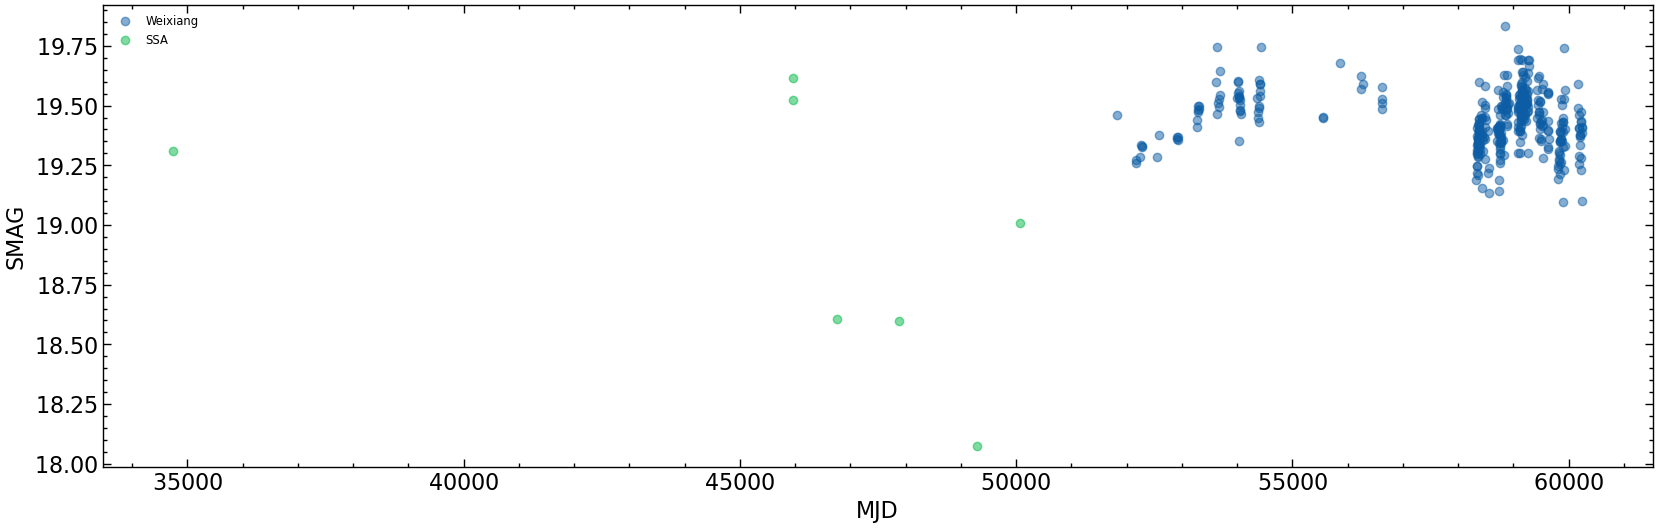

Plotting 1384155


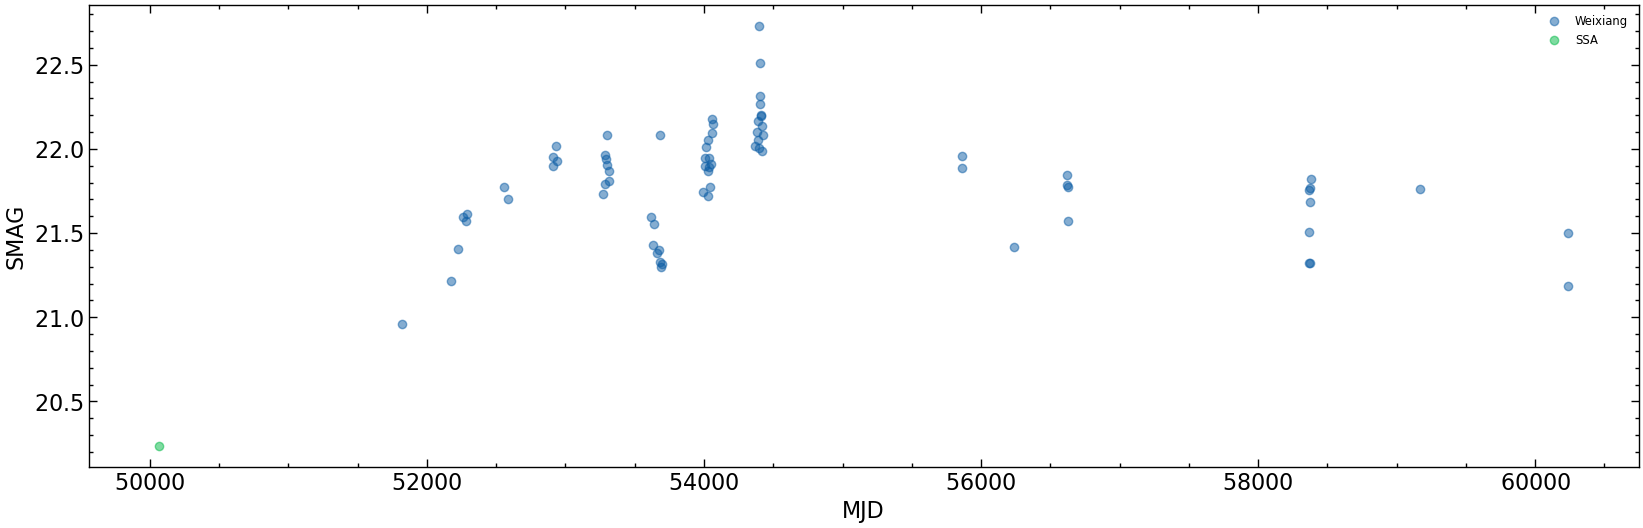

Plotting 1384156


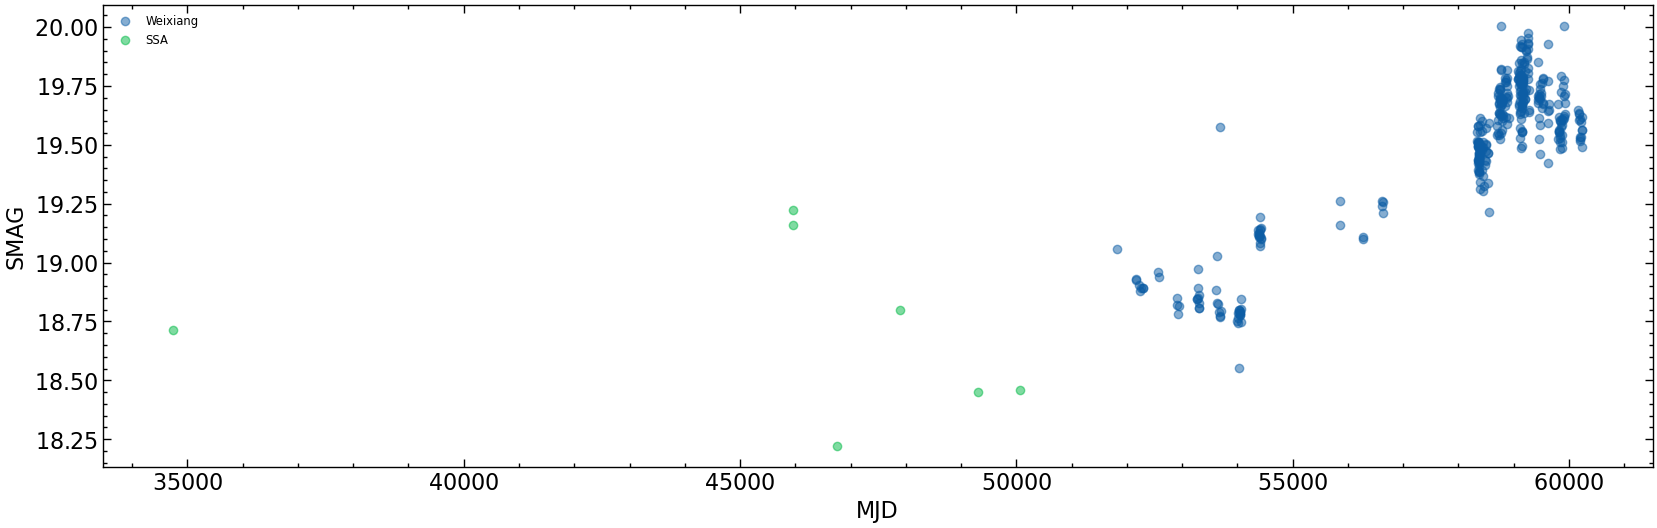

Plotting 1384157


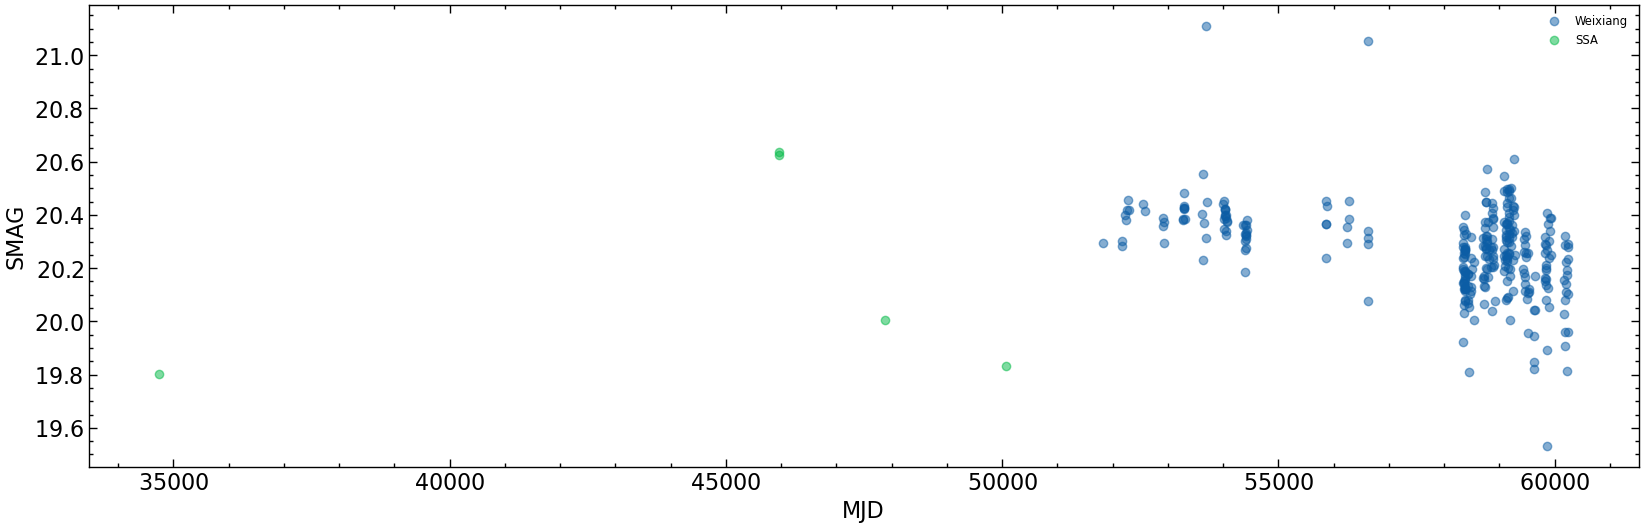

Plotting 1384158


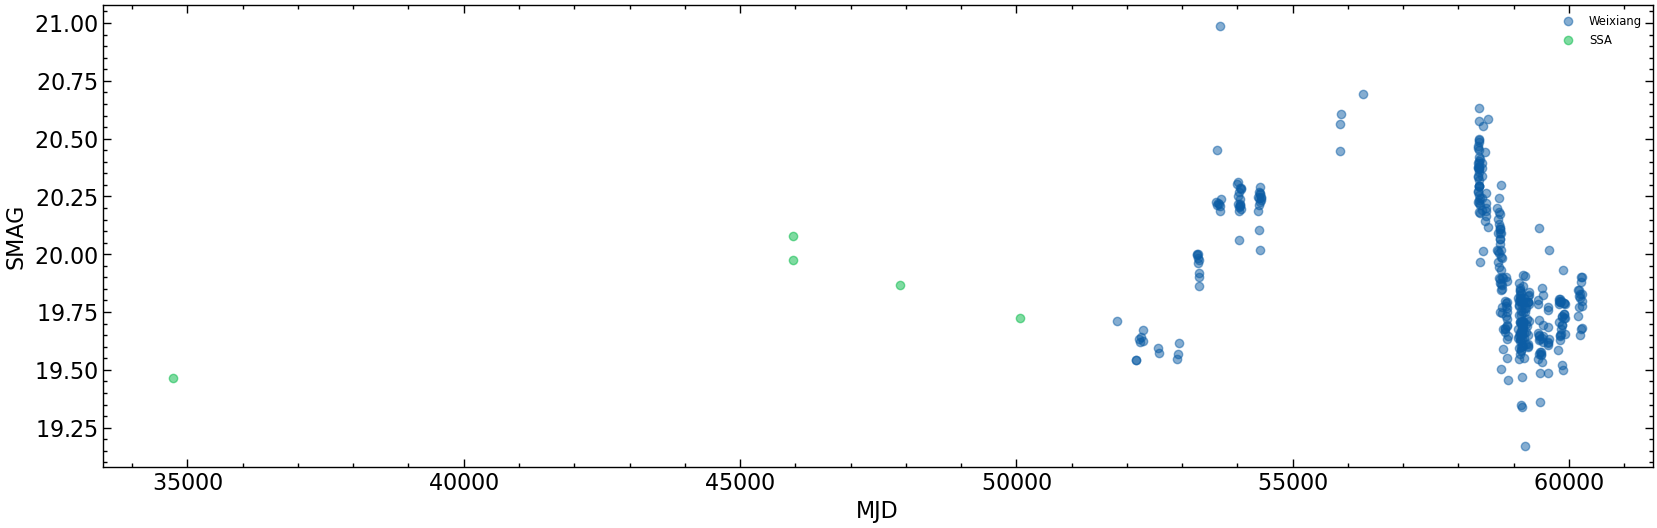

Plotting 1384159


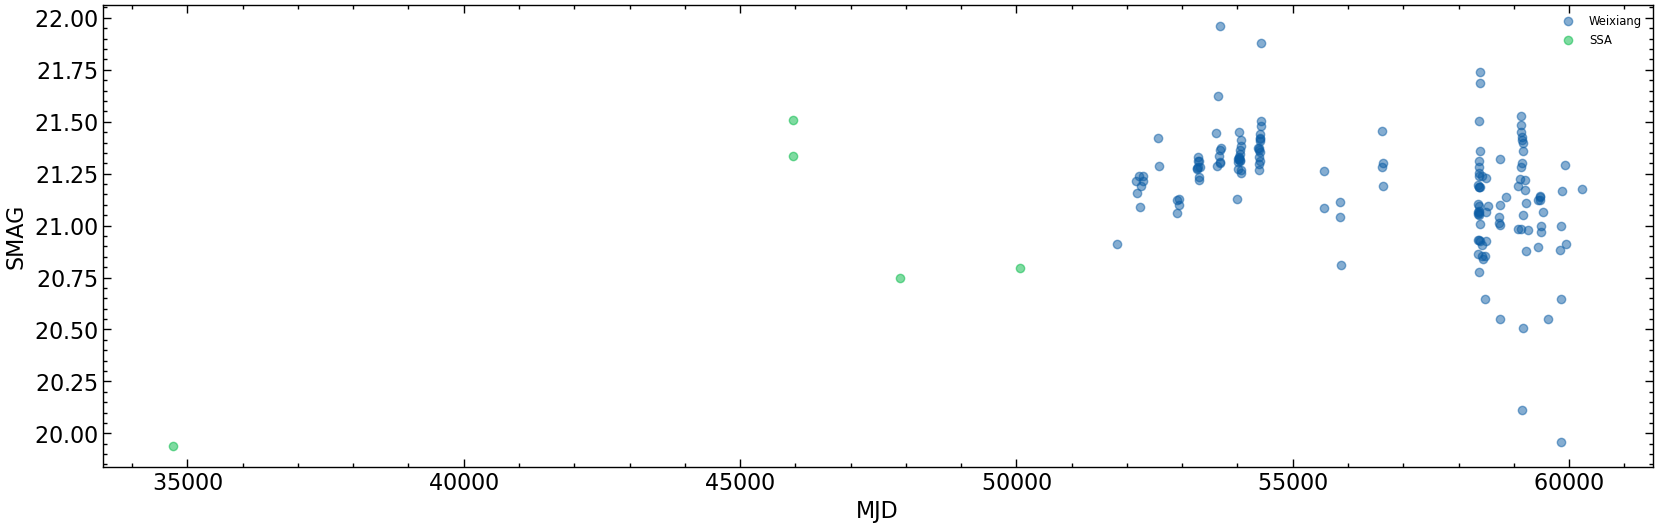

Plotting 1384160


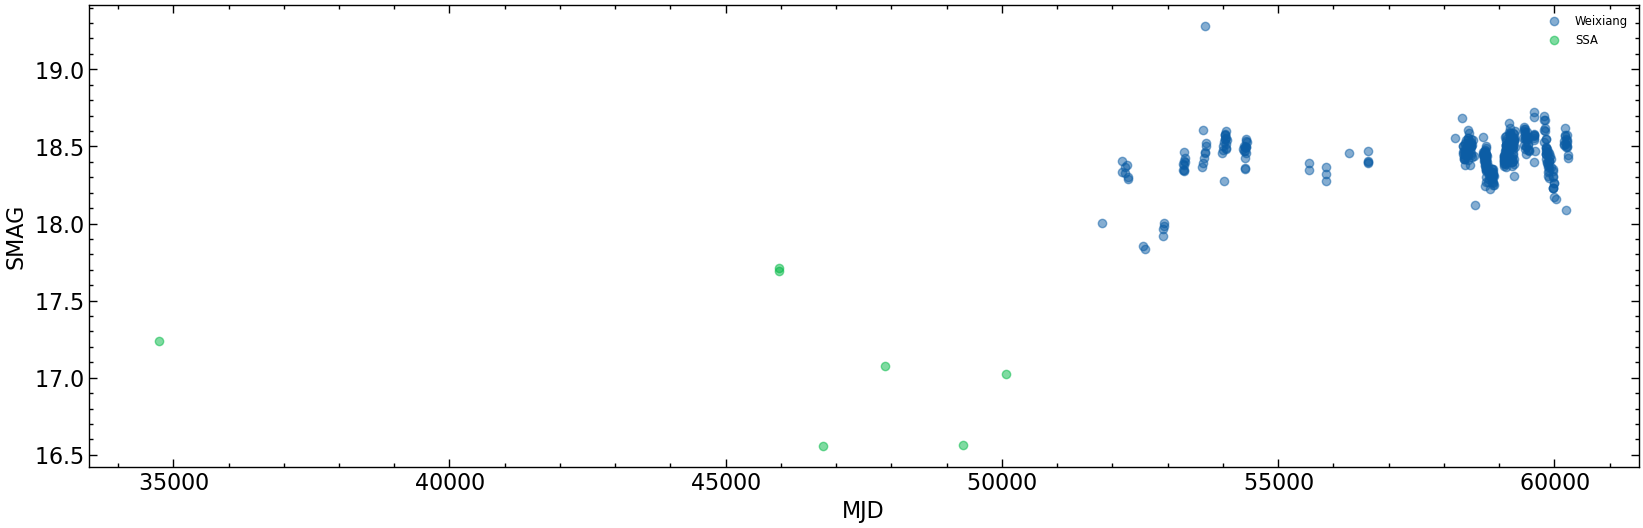

Plotting 1384161


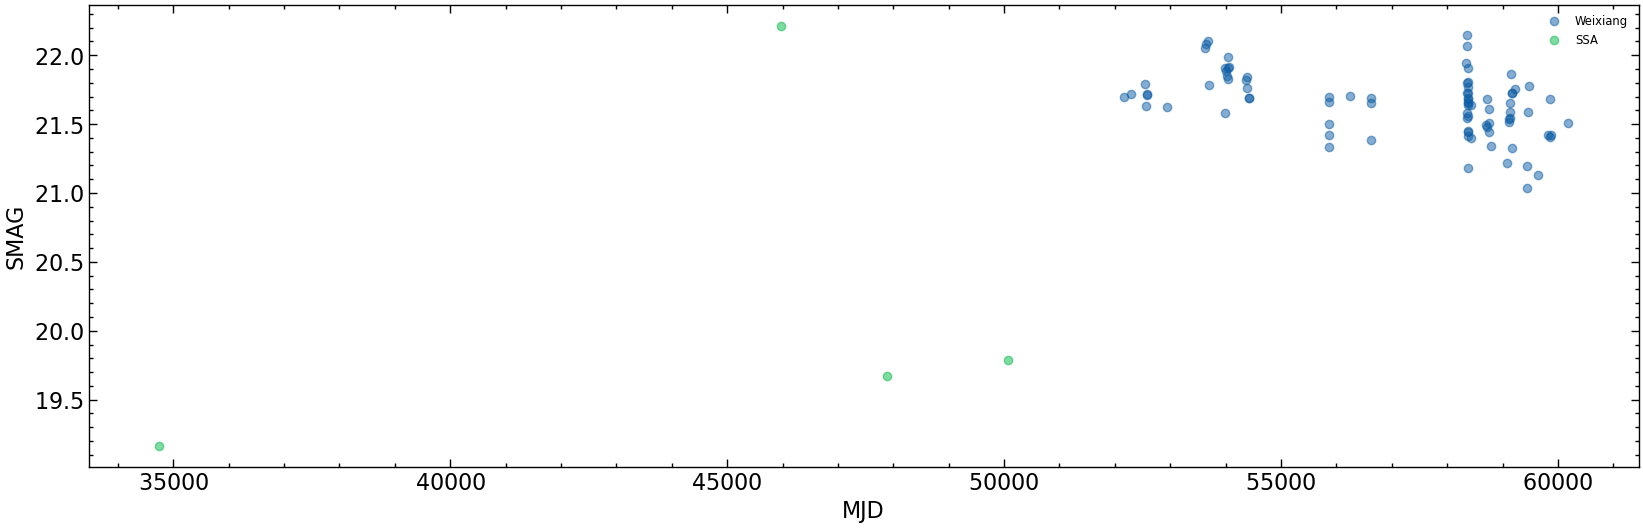

In [125]:
from astropy.coordinates import search_around_sky
# Match lc_data with joined_table using object_id
matched_lc_data = []
matched_joined_data = []

for obj in lc_data:
    obj_id = int(obj['object_id'])
    # Find rows in joined_table with matching object_id
    mask = (joined_table['UP_NAME'] == obj_id) & (joined_table['DISTANCE'] < 0.03).flatten()
    matched_rows = joined_table[mask]
    
    if len(matched_rows) > 0:
        matched_lc_data.append(obj)
        matched_joined_data.append(matched_rows)

n_plot = 20

# Plot the combined light curves
for i, obj in enumerate(matched_lc_data[:n_plot]):
    print(f'Plotting {obj["object_id"]}')

    plt.figure(figsize=(20, 6))
    mjd = obj['times']['g']
    smag = obj['mags']['g']
    plt.errorbar(mjd, smag, linestyle='none', marker='o', alpha=0.5, label='Weixiang')

    # Use same UPID to join multiple detections

    plt.errorbar(matched_joined_data[i]['MJD'], matched_joined_data[i]['SMAG'], linestyle='none', marker='o', alpha=0.5, label='SSA')
    plt.xlabel('MJD')
    plt.ylabel('SMAG')
    plt.legend(loc='best', fontsize='small')
    plt.show()


#### STD stars

http://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html

The random photometric errors are below 0.01 mag for stars brighter than (19.5, 20.5, 20.5, 20, 18.5) in ugriz, respectively (about twice as good as for individual SDSS runs). The spatial variation of photometric zeropoints is not larger than 0.01 mag (rms). After 41 header lines, the catalog data file includes one line per star, and each line lists (in this order):

0) every line starts with the string CALIBSTARS
1) RA Dec RArms Decrms: the mean position and its rms per coordinate,
     this is J2000, decimal degrees for RA and Dec, and arcsec for rms
     NB: standard errors can be computed as rms/sqrt(Ntot)
2) Ntot: the total number of epochs
3) Ar: the Schlegel, Finkbeiner & Davis (1998) ISM extinction value in 
    the r band; extinction in other bands can be computed as [Rv=3.1]: 
     Am = Cm*Ar, with Cm=(1.873, 1.377, 0.758, 0.537) for m=(ugiz) 
4) and then in each band (ugriz, in this order):
      (Nobs mmed mmu msig mrms mchi2), which are: 
      the total number of observations in this band
      the median magnitude 
      the mean magnitude
      the standard error for the mean (1.25 larger for the median)
      the root-mean-square scatter
      chi2 per degree of freedom (computed using the mean magnitude)
Note that this catalog can also be used to calibrate photometric data obtained in standard BVRI bandpasses by applying griz to BVRI transformations described in Ivezic et al. 2007 (Astronomical Journal, 134, 973). For more details, in case of problems, etc., send email to Z. Ivezic (ivezic@astro.washington.edu). Technical and other information about SDSS can be found on www.sdss.org.

In [ ]:
import requests

# URL of the catalog
url = "http://faculty.washington.edu/ivezic/sdss/calib82/dataV2/stripe82calibStars_v4.2.dat"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open("stripe82calibStars_v4.2.dat", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


File downloaded successfully.


In [127]:
# Read the catalog into a pandas DataFrame
# Assuming the file is space-delimited and has a header
catalog = pd.read_csv("stripe82calibStars_v4.2.dat", delim_whitespace=True, comment='#')

# Create SkyCoord objects for the catalog
catalog_coords = SkyCoord(ra=catalog.iloc[:, 1].to_numpy() * u.degree, dec=catalog.iloc[:, 2].to_numpy() * u.degree, frame='icrs')
print(len(catalog_coords))

catalog.head()

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_59425/451745936.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog = pd.read_csv("stripe82calibStars_v4.2.dat", delim_whitespace=True, comment='#')


991471


,CALIBSTARS_0000001,308.500219,-1.227713,0.0227,0.0227.1,7,0.587,3,23.870,23.823,...,20.202,0.015,0.046,1.105,7.3,19.900,19.818,0.040,0.116,1.212
0,CALIBSTARS_0000002,308.500072,-1.240266,0.0141,0.0141,7,0.596,4,21.970,21.966,...,19.504,0.013,0.032,0.808,7,19.439,19.386,0.034,0.095,0.824
1,CALIBSTARS_0000003,308.500101,-1.217158,0.0154,0.0154,7,0.579,7,19.394,19.385,...,17.050,0.005,0.027,1.752,6,16.873,16.874,0.007,0.004,0.215
2,CALIBSTARS_0000004,308.501912,-1.176494,0.0117,0.0117,7,0.559,7,20.605,20.598,...,17.188,0.006,0.007,0.496,7,16.968,16.966,0.009,0.022,0.653
3,CALIBSTARS_0000005,308.504615,-1.174191,0.0400,0.0400,7,0.556,2,23.955,23.985,...,20.331,0.016,0.061,1.381,7,19.861,19.747,0.036,0.168,1.733
4,CALIBSTARS_0000006,308.501254,-1.119302,0.0166,0.0166,8,0.537,3,22.436,22.454,...,18.763,0.009,0.010,0.146,8,18.515,18.505,0.015,0.016,0.403
